In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

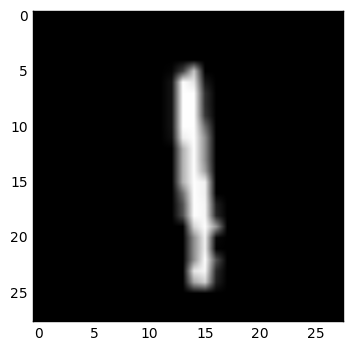

In [4]:
plt.imshow(X_train[8], cmap='gray')
plt.show()

In [5]:
input_dim = 784
n_l1 = 500
n_l2 = 200
z_dim = 2
batch_size = 1000

lr = 1e-3

In [27]:
tf.reset_default_graph()

In [28]:
sess.close()

In [29]:
def dense(x, n1, n2, name):
    with tf.variable_scope(name, reuse=None):
        W = tf.get_variable("weights", shape=[n1,n2],
                           initializer = tf.random_normal_initializer(mean=0., stddev=0.01))
        b = tf.get_variable("bias", shape=[n2], initializer=tf.constant_initializer(0.))
        out = tf.matmul(x, W) + b
        return out

In [30]:
def encoder(x):
    with tf.name_scope('Encoder'):
        e_dense_1 = tf.nn.relu(dense(x, input_dim, n_l1, 'e_dense_1'))
        e_dense_2 = tf.nn.relu(dense(e_dense_1, n_l1, n_l2, 'e_dense_2'))
        z_means = dense(e_dense_2, n_l2, z_dim, 'e_means')
        z_stds = dense(e_dense_2, n_l2, z_dim, 'e_stds')
        return z_means, z_stds        

In [31]:
def decoder(x):
    with tf.name_scope('Decoder'):
        d_dense_1 = tf.nn.relu(dense(x, z_dim, n_l2, 'd_dense_1'))
        d_dense_2 = tf.nn.relu(dense(d_dense_1, n_l2, n_l1, 'd_dense_2'))
        output = tf.nn.sigmoid(dense(d_dense_2, n_l1, input_dim, 'd_out'))
        return output

In [32]:
x_input = tf.placeholder(dtype = tf.float32, shape = [None, input_dim])
x_target = tf.placeholder(dtype=tf.float32, shape = [None, input_dim])

z_means, z_stds = encoder(x_input)

samples = tf.random_normal([batch_size, z_dim], 0, 1, dtype=tf.float32)
decoder_input1 = z_means + (z_stds*samples)
decoder_output1 = decoder(decoder_input1)

In [33]:
loss_gen = tf.reduce_sum(tf.square(x_target - decoder_output1))
loss_latent = 0.5*tf.reduce_sum(tf.square(z_means) + tf.square(z_stds) - tf.log(tf.square(z_stds)) - 1,1)
loss = loss_gen + loss_latent

In [34]:
train = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [35]:
sess = tf.Session()

In [36]:
sess.run(tf.global_variables_initializer())
for i in tqdm(range(50)):
    permutations = list(np.random.permutation(60000))
    num_batches = int(np.floor((60000-1)/batch_size))
    for k in range(0, num_batches+1):
        indexes = permutations[k*batch_size:(k+1)*batch_size]
        mb_X= np.vstack([X_train[i].reshape(-1,)/255 for i in indexes])
        sess.run(train, feed_dict = {x_input:mb_X, x_target : mb_X})

100%|██████████| 50/50 [07:24<00:00,  8.90s/it]


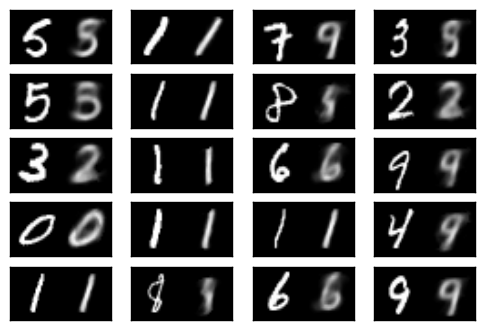

In [37]:
_, ax = plt.subplots(5, 4)
indexes = np.random.choice(60000,1000,replace=False)
mb_X= np.vstack([X_train[i].reshape(-1,)/255 for i in indexes])
gen_output = sess.run(decoder_output1, feed_dict = {x_input:mb_X})
for i in range(20):
    img = np.hstack((X_train[indexes[i]],gen_output[i].reshape(28,28)*255))
    ax[i//4,i%4].imshow(img, cmap='gray')
    ax[i//4,i%4].set_xticks([])
    ax[i//4,i%4].set_yticks([])
    ax[i//4,i%4].set_aspect('auto')
plt.show()

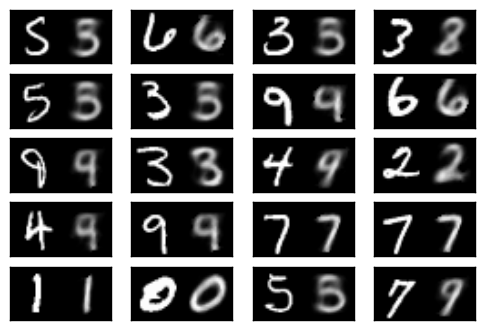

In [38]:
_, ax = plt.subplots(5, 4)
indexes = np.random.choice(10000, 1000,replace=False)
mb_X= np.vstack([X_test[i].reshape(-1,)/255 for i in indexes])
gen_output = sess.run(decoder_output1, feed_dict = {x_input:mb_X})
for i in range(20):
    img = np.hstack((X_test[indexes[i]],gen_output[i].reshape(28,28)*255))
    ax[i//4,i%4].imshow(img, cmap='gray')
    ax[i//4,i%4].set_xticks([])
    ax[i//4,i%4].set_yticks([])
    ax[i//4,i%4].set_aspect('auto')
plt.show()

In [53]:
arr = np.arange(-5.,5.1,1.)
values = []
for i in range(121):
    values.append([arr[i%11],arr[i//11]])
values = np.array(values)

values.shape

(121, 2)

In [54]:
inpt = np.vstack((values, np.zeros((879,2))))

In [55]:
gen_numbers = sess.run(decoder_output1, feed_dict={decoder_input1: inpt})

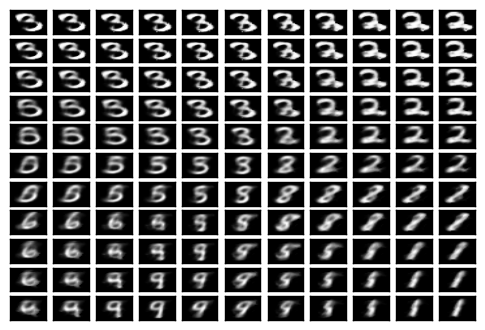

In [56]:
_, ax = plt.subplots(11, 11)
for i in range(121):
    ax[i//11,i%11].imshow(gen_numbers[i].reshape(28,28)*255, cmap='gray')
    ax[i//11,i%11].set_xticks([])
    ax[i//11,i%11].set_yticks([])
    ax[i//11,i%11].set_aspect('auto')
plt.show() 